<h1 style="text-align:center;">University of Denver</h1>
<h3 style="text-align:center;">Alex Liddle</h3>
<br>
<h2 style="text-align:center;">Using Generative Adversarial Networks for Deepfake Detection</h2>

<h4 style="text-align:center;">Abstract</h4>
The purpose of this project is to explore the application of a Generative Adversarial Network (GAN) to detect deepfakes; specifically, the generator will produce deepfakes, while the discriminator will detect them. Deepfakes involve the process of pasting one person’s face onto another’s in a manner so realistic that it is nearly impossible to tell that it is not a real image. The end goal of this project is to have a trained discriminator that is capable of accurately detecting a deepfake since it was involved in the learning process, competing against the generator. The dataset for this project is available on Kaggle at https://www.kaggle.com/jessicali9530/celeba-dataset/. The dataset includes 202,599 face images of 10,177 unique celebrities. The images are mostly front facing, though some angles are slightly off center, hiding either the left or right ear of the subject. The model pipeline consists of a face detection algorithm, a generator neural network, and a discriminator neural network. Due to the time constraints of the quarter during which the project was developed, in addition to limited computational resources, the trained model is far from being able to detect deepfakes, though early results are promising.

#### Introduction
In a world where the majority of people on social media assume information based on their initial impression of a photo or short video, deepfakes are increasingly being used to spread fake news. These fake representations can have potentially devastating consequences on a national level, for example if person in a government position was portrayed doing something damaging or treasonous. We can identify a lot of deepfakes because they have been labeled as such. The problem is the ones we do not know about. How do we train an algorithm to identify a deepfake if we cannot tell it whether or not it is succesful?  Generative Adversarial Networks (GANs) have gained a lot of traction recently. The theory behind them has been discussed for some time, but it is only in the last decade that computational resources have improved to the point that people could start creating and training them. The proposition is that a GAN can be used to create a deepfake detector by taking part in the training process of a deepfake generator. 


In [1]:
import numpy as np
import pandas as pd

import os
import time

from matplotlib import pyplot as plt

from tqdm import tqdm
from PIL import Image as Img
from keras import Input
from keras.layers import Dense, Reshape, LeakyReLU, Conv2D, Conv2DTranspose, Flatten, Dropout
from keras.models import Model
from keras.optimizers import RMSprop
import cv2

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

#### Dataset
The dataset for this project is available on Kaggle at https://www.kaggle.com/jessicali9530/celeba-dataset/. The dataset includes 202,599 face images of 10,177 unique celebrities. The images are mostly front facing, though some angles are slightly off center, hiding either the left or right ear of the subject.

#### Load the data and resize the images

In [2]:
PIC_DIR = f'./img_align_celeba/'

IMAGES_COUNT = 10000

ORIG_WIDTH = 178
ORIG_HEIGHT = 208
diff = (ORIG_HEIGHT - ORIG_WIDTH) // 2

WIDTH = 128
HEIGHT = 128

crop_rect = (0, diff, ORIG_WIDTH, ORIG_HEIGHT - diff)

images = []
count=0
for filepath in tqdm(os.listdir(PIC_DIR)[:IMAGES_COUNT]):
    image = Img.open(PIC_DIR + filepath).crop(crop_rect)
    image.thumbnail((WIDTH, HEIGHT), Img.ANTIALIAS)
    images.append(np.uint8(image))
    count += 1

100%|██████████| 10000/10000 [00:12<00:00, 806.39it/s]


### Display first 25 images

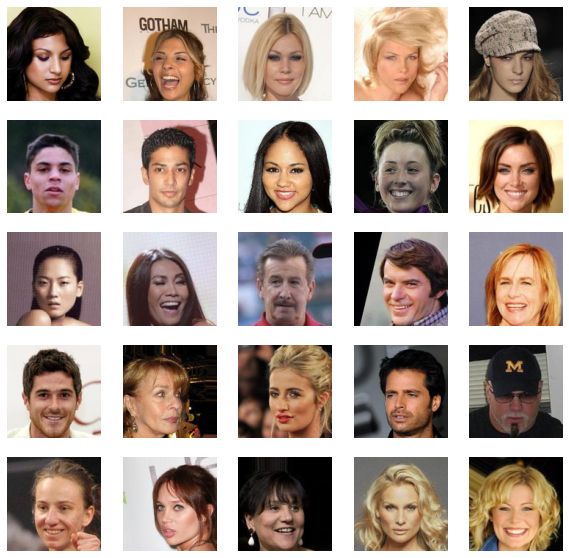

In [3]:
#Display first 25 images
plt.figure(1, figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(images[i])
    plt.axis('off')
plt.show()

#### Model
##### Face Detection
The pipeline consists of a face detection model, a generator, and a discriminator. The face detection model employs the Haar Cascade algorithm. It works by detecting a set of specific features: horizontal and vertical edges, horizontal and vertical lines, and four-rectangle features. For the face detection model, a set of features must be present – lips (horizontal line), nose (vertical line), and so on. When these features are found, and they are organized in an expected pattern, then a face is detected.


In [4]:
def detect_face(image):
    cascPath = "haarcascade_frontalface_default.xml"
    # Create the haar cascade
    faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + cascPath)
    # Read the image
    image = cv2.normalize(image, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, 
                          dtype = cv2.CV_32F)
    image = image.astype(np.uint8)
    gray = cv2.cvtColor(np.uint8(image), cv2.COLOR_BGR2GRAY)
    # Detect faces in the image
    faces = faceCascade.detectMultiScale(gray, 1.1, 4)
    # Draw a rectangle around the faces
    face = []
    if len(faces)==0:
        orig_faces.append([face,(1,1,1,1)])
    for (x, y, w, h) in faces:
        face = image[x:x+w, y:y+h]
        if face is not None:
            #face = cv2.normalize(face, None, alpha = 0, beta = 1, norm_type = cv2.NORM_MINMAX, 
            #              dtype = cv2.CV_32F)
            orig_faces.append([face, (x, y, x+w, y+h)])
            break 

Images were read into a list using the Image module from PIL python library. Next, a copy of the list will be created and randomly shuffled using Numpy’s random.shuffle module. Both lists will be processed by a face detection algorithm. The faces and coordinates for each face in each list will be appended to an unmixed list and a shuffled list for the unchanged and shuffled image lists, respectively. Finally, both lists will be iterated over, a random face will be drawn from the shuffled list and cropped using the face detection coordinates, then it will be resized to match the dimensions of the face on which it is to be pasted.

In [5]:
orig = images.copy()
orig_faces = []
for img in orig:
    detect_face(img)
    
# Generate a list of faces with their detected coordinates
faces = [face[0] for face, coord in orig_faces if len(face) != 0]
coords = [coord for face, coord in orig_faces if len(face) != 0]

# Copy face list and shuffle so faces can be randomly swapped
random_faces = orig_faces.copy()
np.random.shuffle(random_faces)

rand_faces = [face for face, coord in random_faces if len(face) != 0]
rand_coords = [coord for face, coord in random_faces if len(face) != 0]

# Randomly swap faces
for face in range(len(faces)):
    src = faces[face]
    new = rand_faces[face]       

    x1,y1,x2,y2 = coords[face]
    
    # Store width of original face so new face can match dimensions
    width = int(orig[face][x1:x2, y1:y2].shape[1])
    height = int(orig[face][x1:x2, y1:y2].shape[0])

    # dsize
    dsize = (width, height)

    # resize image
    output = cv2.resize(new, dsize)

    output = cv2.normalize(output, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    output = output.astype(np.float32)
    # paste new face onto the source face
    orig[face]=cv2.normalize(orig[face].copy(), None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    orig[face][x1:x2, y1:y2] = output.copy()

    # Update model input list
    faces[face] = list(cv2.resize(orig[face], (12, 12)).flatten().reshape(1,-1)[0])



##### GAN: Generator
The next stage in the pipeline is the generator of the GAN. The generator is essentially the decoder half of an autoencoder. It immediately upsamples the input image from 12 x 12 x 3 to 16 x 16 x 128 pixels, before passing it from one convolutional hidden layer to another, increasing the dimensionality as it moves along. The generator is made up of seven layers – Input, Dense, Convolutional, three Convolutional Transposes, and two additional Convolutional layers. A Leaky ReLu activation function is used on the first and last two layers. In total, the generator consists of 38, 813, 572 trainable parameters.

In [6]:
LATENT_DIM = 432
CHANNELS = 3

def create_generator():
    gen_input = Input(shape=(LATENT_DIM, ))

    x = Dense(128 * 16 * 16)(gen_input)
    x = LeakyReLU()(x)
    x = Reshape((16, 16, 128))(x)

    x = Conv2D(128, 5, padding='same')(x)

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)#256

    x = Conv2DTranspose(513, 4, strides=2, padding='same')(x)#256

    x = Conv2DTranspose(1024, 4, strides=2, padding='same')(x)#256
    x = LeakyReLU()(x)

    x = Conv2D(512, 5, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(CHANNELS, 7, activation='tanh', padding='same')(x)

    generator = Model(gen_input, x)
    return generator

##### GAN: Discriminator
The final stage in the pipeline is the discriminator of the GAN. The discriminator is a deep convolutional neural network with five hidden layers. The first hidden layer has a dimension of 126 x 126 x 256. Subsequent layers have their dimensionality reduced by the kernel of the convolution. Each layer has a Leaky ReLu activation function except for the output layer, which has a sigmoid activation, since its purpose is to identify images produced by the generator as either real or fake. In total, the discriminator has 4,211,713 trainable parameters.

In [7]:
def create_discriminator():
    disc_input = Input(shape=(HEIGHT, WIDTH, CHANNELS))

    x = Conv2D(256, 3)(disc_input)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Flatten()(x)
    x = Dropout(0.4)(x)

    x = Dense(1, activation='sigmoid')(x)
    discriminator = Model(disc_input, x)

    optimizer = RMSprop(
        lr=.0001,
        clipvalue=1.0,
        decay=1e-8
    )

    discriminator.compile(
        optimizer=optimizer,
        loss='binary_crossentropy'
    )

    return discriminator

##### GAN model assembly

In [8]:
generator = create_generator()
generator.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 432)]             0         
_________________________________________________________________
dense (Dense)                (None, 32768)             14188544  
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32768)             0         
_________________________________________________________________
reshape (Reshape)            (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 128)       409728    
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 32, 32, 256)       524544    
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 64, 64, 513)       210176

In [9]:
discriminator = create_discriminator()
discriminator.trainable = False
discriminator.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 126, 126, 256)     7168      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 126, 126, 256)     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 62, 62, 256)       1048832   
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 62, 62, 256)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 30, 30, 256)       1048832   
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 30, 30, 256)       0   

In [10]:
gan_input = Input(shape=(LATENT_DIM, ))
gan_output = discriminator(generator(gan_input))
gan = Model(gan_input, gan_output)

In [11]:
optimizer = RMSprop(lr=.0001, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=optimizer, loss='binary_crossentropy')

In [12]:
gan.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 432)]             0         
_________________________________________________________________
model (Functional)           (None, 128, 128, 3)       38813572  
_________________________________________________________________
model_1 (Functional)         (None, 1)                 4211713   
Total params: 43,025,285
Trainable params: 38,813,572
Non-trainable params: 4,211,713
_________________________________________________________________


#### Training the model:

Training happens in two phases. First, the model is overfit on three to five unaltered images to quickly initialize the weights to match those that would be expected in a model whose purpose is to produce images of faces. Once the model accurately reproduces the images it has trained on (approximately 500 epochs with a batch size of 3), then the training data is altered with the face detection and pasting algorithm. The generator is fed the altered images and attempts to produce a realistic image from them. The images it generates are paired with unaltered images and they are labeled as fake and real, respectively. The discriminator then trains on them, attempting to accurately identify them according to the labels. A binary cross entropy loss function is used to change the weights of the models based on the success or failure of the discriminator. If the discriminator is successful, the generator is punished, and vice versa. 

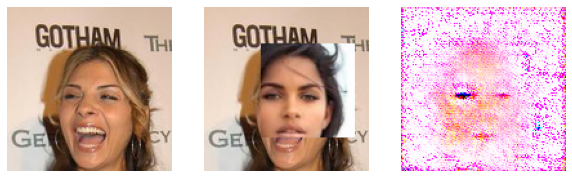

50/15000: d_loss: -0.1536,  a_loss: 30.9100.  (3.6 sec)


In [ ]:
iters = 15000
batch_size = 4

RES_DIR = 'results'
FILE_PATH = '%s/generated_%d.png'
if not os.path.isdir(RES_DIR):
    os.mkdir(RES_DIR)

start = 0
d_losses = []
a_losses = []

weights_file = "./gan.h5"
if os.path.isfile(weights_file): 
    gan.load_weights("./gan.h5")
    
control_image = faces[1]
images_other = images[2:]

for step in range(iters):
    start_time = time.time()
    # Create GAN input
    latent_vectors = np.array(faces[start:start + batch_size])
    
    # Generate output from generator
    generated = generator.predict(latent_vectors)

    # Get real images
    real = images_other[start:start + batch_size]
    
    # Combine and label fake and real images for the discriminator to train on
    combined_images = np.concatenate([generated, real])

    labels = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])
    labels += .05 * np.random.random(labels.shape)
    
    d_loss = discriminator.train_on_batch(combined_images, labels)
    d_losses.append(d_loss)

    # Create misleading targets to avoid mode collapse of the discriminator
    misleading_targets = np.zeros((batch_size,1))

    a_loss = gan.train_on_batch(latent_vectors, misleading_targets)
    a_losses.append(a_loss)

    start += batch_size
    if start > np.array(images_other).shape[0] - batch_size:
        start = 0

    if step % 50 == 49:
        gan.save_weights('./gan.h5')

        control = generator.predict(np.array([control_image]))
        plt.figure(1, figsize=(10, 10))
        for i in range(1):
            plt.subplot(1, 3, i+1)
            plt.imshow(images[1])
            plt.axis('off')
            plt.subplot(1, 3, i+2)
            plt.imshow(orig[1])
            plt.axis('off')
            plt.subplot(1, 3, i+3)
            plt.imshow(control[i])
            plt.axis('off')
        plt.show()
    
        print('%d/%d: d_loss: %.4f,  a_loss: %.4f.  (%.1f sec)' % (step + 1, iters, d_loss, a_loss, time.time() - start_time))
